Step 1

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras import layers, models
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from google.colab import drive

Step 2

In [2]:
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
dataset_path = '/content/drive/MyDrive/mlpr/AllImages'

In [4]:
IMG_SIZE = (224, 224)
BATCH_SIZE = 32
RANDOM_SEED = 42

In [5]:
train_ds = image_dataset_from_directory(
    dataset_path,
    validation_split=0.2,
    subset="training",
    seed=RANDOM_SEED,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE
)

val_ds = image_dataset_from_directory(
    dataset_path,
    validation_split=0.2,
    subset="validation",
    seed=RANDOM_SEED,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE
)

class_names = train_ds.class_names
print(f"Class names: {class_names}")

Found 178 files belonging to 7 classes.
Using 143 files for training.
Found 178 files belonging to 7 classes.
Using 35 files for validation.
Class names: ['10 Note', '100 Note', '20 Note', '200 Note', '2000 Note', '50 Note', '500 Note']


Step 3

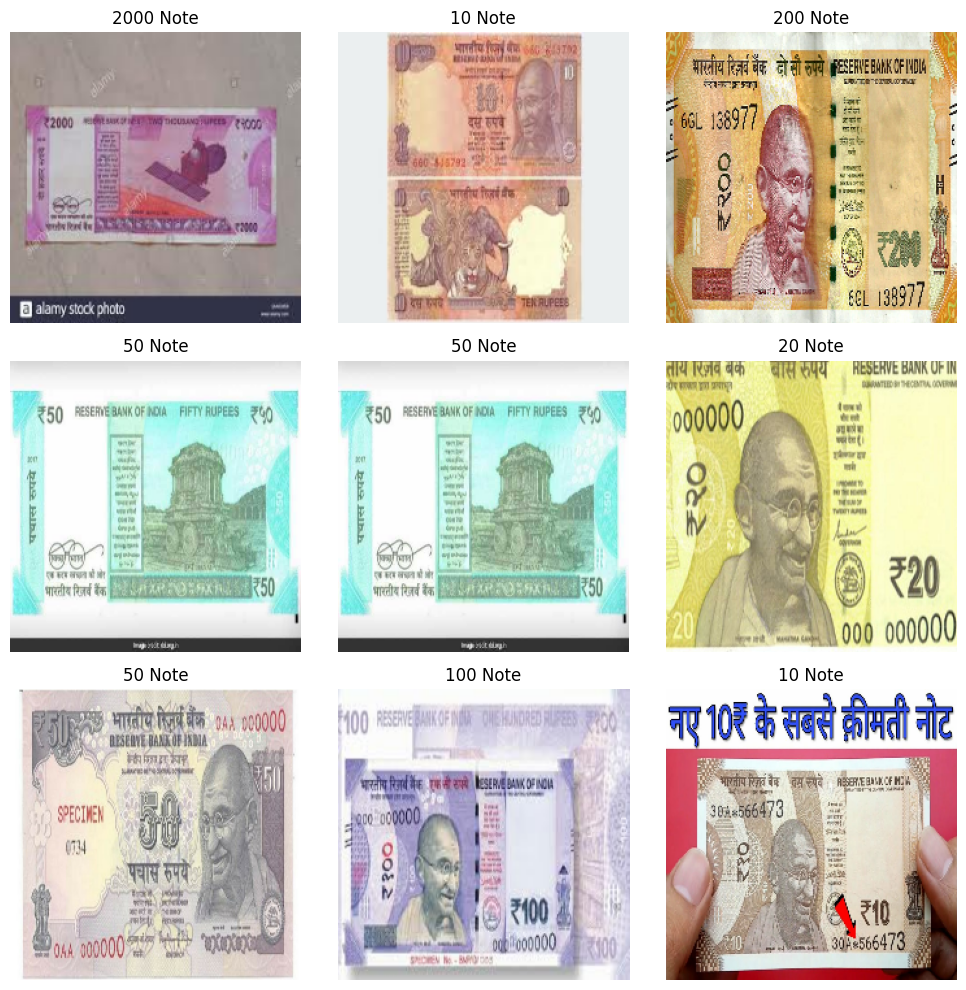

In [6]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")
plt.tight_layout()
plt.show()

In [7]:
##data augmentation for the training set

data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
])
train_ds = train_ds.map(lambda x, y: (data_augmentation(x, training=True), y))
#optimize for performance
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.prefetch(buffer_size=AUTOTUNE)



Step 4 : load pretrained ResNet50 & extract features from last layer

In [8]:
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False  # Freeze the base model
def extract_features(dataset):
    features = []
    labels = []

    for image_batch, label_batch in dataset:
        # Preprocess images for ResNet50
        preprocessed_batch = preprocess_input(image_batch)

        # Extract features using the base model
        feature_batch = base_model.predict(preprocessed_batch)

        # Flatten the features
        flat_features = tf.reshape(feature_batch, (feature_batch.shape[0], -1))

        # Store features and labels
        features.append(flat_features)
        labels.append(label_batch)

    # Concatenate all batches
    features = np.vstack(features)
    labels = np.concatenate(labels)

    return features, labels

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [9]:
train_features, train_labels = extract_features(train_ds)
val_features, val_labels = extract_features(val_ds)

1/1 ━━━━━━━━━━━━━━━━━━━━ 10s 10s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 452ms/step


In [10]:
print(f"Training features shape: {train_features.shape}")
print(f"Validation features shape: {val_features.shape}")

Training features shape: (143, 100352)
Validation features shape: (35, 100352)


Step 5: Training SVM classifier

In [11]:
svm_classifier = SVC(kernel='rbf', probability=True)
svm_classifier.fit(train_features, train_labels)

SVC(probability=True)

Step 6: Making prediction

In [12]:
val_predictions = svm_classifier.predict(val_features)

Step 7: Performance metrics

Accuracy: 0.4857

Classification Report:
              precision    recall  f1-score   support

     10 Note       0.44      1.00      0.62         4
    100 Note       0.22      0.67      0.33         3
     20 Note       1.00      0.43      0.60         7
    200 Note       0.33      0.25      0.29         4
   2000 Note       1.00      0.67      0.80         6
     50 Note       0.00      0.00      0.00         5
    500 Note       0.50      0.50      0.50         6

    accuracy                           0.49        35
   macro avg       0.50      0.50      0.45        35
weighted avg       0.57      0.49      0.47        35



<Figure size 1000x800 with 0 Axes>

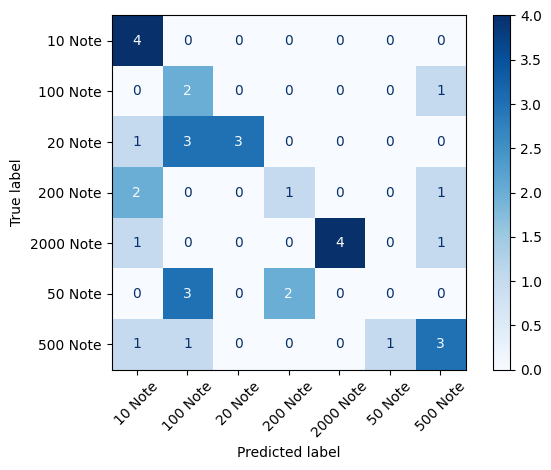

In [13]:
accuracy = accuracy_score(val_labels, val_predictions)
print(f"Accuracy: {accuracy:.4f}")
print("\nClassification Report:")
print(classification_report(val_labels, val_predictions, target_names=class_names))
cm = confusion_matrix(val_labels, val_predictions)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
plt.figure(figsize=(10, 8))
disp.plot(cmap=plt.cm.Blues)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


Step 8: Displaying classified images with their labels

1/1 ━━━━━━━━━━━━━━━━━━━━ 8s 8s/step


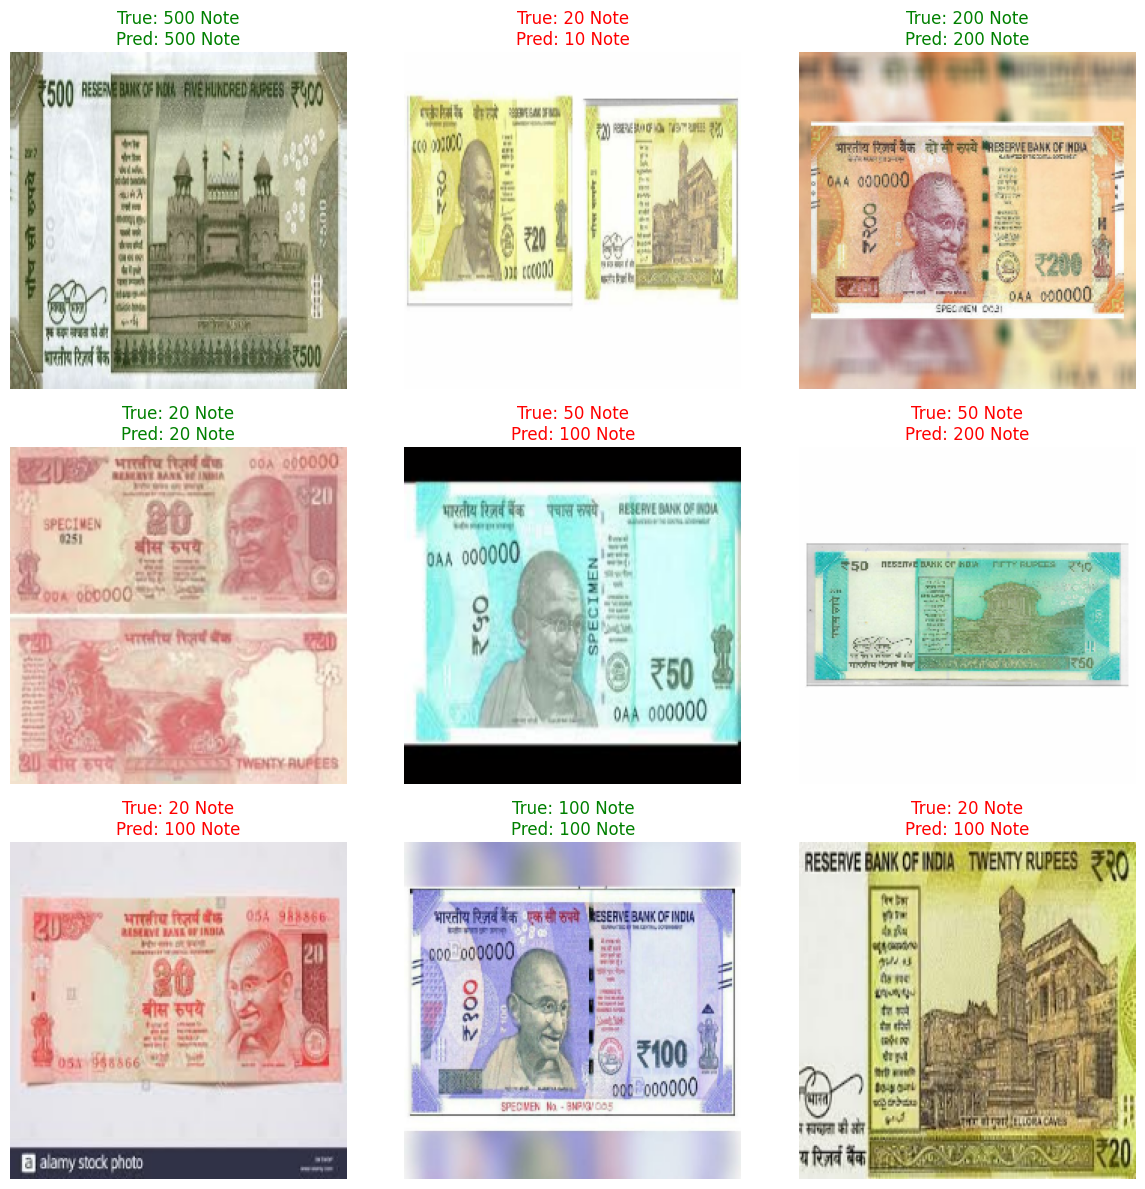

In [14]:
plt.figure(figsize=(12, 12))
count = 0
for images, labels in val_ds:
    preprocessed_images = preprocess_input(images.numpy())
    features = base_model.predict(preprocessed_images)
    features = features.reshape(features.shape[0], -1)
    predictions = svm_classifier.predict(features)

    for i in range(min(9, len(images))):
        if count >= 9:
            break
        ax = plt.subplot(3, 3, count + 1)
        plt.imshow(images[i].numpy().astype("uint8"))

        predicted_class = class_names[int(predictions[i])]
        true_class = class_names[int(labels[i])]

        title = f"True: {true_class}\nPred: {predicted_class}"
        plt.title(title, color=("green" if predicted_class == true_class else "red"))
        plt.axis("off")
        count += 1

    if count >= 9:
        break

plt.tight_layout()
plt.show()


# Report

## What were the main innovations in ResNet and GoogLeNet?

The key innovation in ResNet is the introduction of skip connections or shortcut connections, which allow the network to bypass one or more layers. These connections enable the flow of information from earlier layers to later ones, helping to mitigate the degradation problem encountered in training deep networks (to address the vanishing gradient problem in deep networks).
GoogLeNet introduced the inception module, which uses multiple filter sizes in parallel to capture features at different scales. Inception module is one of the famous architectures used in Convolutional Neural Networks which was introduced by Google in the ImageNet Large-Scale Visual Recognition Challenge 2014(ILSVRC14) to solve the problem of computational expense, as well as overfitting, among other issues of image claasification and object detection.


## Why do we at times need Transfer Learning?

 transfer learning can minimize the effort of machine learning exploration by using the pre-trained model as the starting point. We can significantly reduce the time required to train a new model using a pre-trained model, as the starting point is already accomplished the learning. Fewer computational resources, as it reuses the learned features from the pre-trained model, minimizing the need for extensive training from scratch. Better performance, particularly in cases where the available data for the new task is limited.

## How can up sampling training set help with Transfer Learning?

Upsampling, or oversampling, a training set can significantly benefit transfer learning by addressing class imbalance and potentially expanding the dataset, which can improve model performance, especially when the target domain has limited labeled data. It provides more training examples for the model to fine-tune, helping to avoid overfitting to the pre-trained features.


## Are there any limitations of using Transfer Learning? List only two.

Two limitations of using transfer learning include negative transfer and overfitting. Negative transfer occurs when the pre-trained model's knowledge hinders performance on the new task, while overfitting happens when the model learns details specific to the training data, reducing its ability to generalize.

## What are the different approaches in Transfer Learning?

Training a Model to Reuse it. The second approach is to use an already pre-trained model. Third is using pre-trained model as a fixed feature extractor.